                2021E  2022E  2023E  2024E  2025E  2026E  2027E  2028E  2029E  \
Sales           -15.0  -15.0  -15.0    5.0   25.0   37.5   56.2   84.4  126.6   
EBIT             -8.8   -8.8   -8.8    3.0   14.8   22.1   33.2   49.8   74.7   
Free Cash Flow    NaN   -8.8   -8.8    2.1   11.5   17.4   26.0   39.0   58.6   

                 2030   2031  
Sales           189.8  284.8  
EBIT            112.0  168.0  
Free Cash Flow   87.9  131.8  


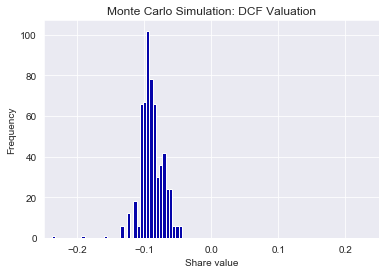

C:\Users\nsw26\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


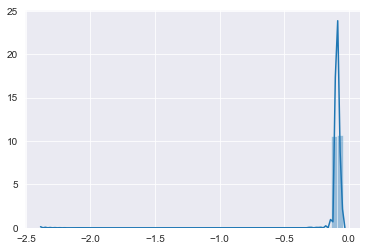

In [8]:
#Adapted from TowardsDataScience (includes biotech-specific modifications)
#https://towardsdatascience.com/automating-the-dcf-valuation-35abde04cdb9

#import libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns


#setup the years 
years=['2021E','2022E','2023E','2024E','2025E', '2026E','2027E','2028E','2029E','2030','2031']
sales=pd.Series(index=years)
sales['2021E']=-15
sales['2022E']=-15
sales['2023E']=-15
sales['2024E']=5
sales['2025E']=25

#revenue growth rate beyond the specified years 
growth_rate=0.50

#for loop for base revenue growth 
for year in range(5,len(sales)):
    sales[year]=sales[year-1]*(1+growth_rate)

#specify the P&L 
ebitda_margin = 0.60
depr_percent = 0.01
ebitda = sales * ebitda_margin
depreciation = sales * depr_percent
ebit = ebitda - depreciation
nwc_percent = 0.01
nwc = sales * nwc_percent 
change_in_nwc = nwc.shift(1)-nwc 
capex_percent = depr_percent 
capex = -(sales * capex_percent)
tax_rate = 0.21 
tax_payment = -ebit * tax_rate
tax_payment = tax_payment.apply(lambda x: min(x,0))
free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc

#DCF inputs
cost_of_capital = 0.2
terminal_growth = 0.02
share_count = 20
POS=0.75

#DCF setup 
terminal_value=((free_cash_flow[-1] * (1+ terminal_growth)) / (cost_of_capital - terminal_growth))
discount_factors = [(1/ (1+cost_of_capital)) ** i for i in range (1,len(sales))]
dcf_value = (sum(free_cash_flow[1:] * discount_factors) + terminal_value * discount_factors[-1])
output = pd.DataFrame([sales,ebit,free_cash_flow],index=['Sales','EBIT','Free Cash Flow']).round(1)

#statistical distributions (normal)
iterations = 100
sales_growth_dist = np.random.normal(loc=0.1,scale=0.1, size=iterations)
ebitda_margin_dist = np.random.normal(loc=0.14,scale=0.02,size=iterations)
nwc_percent_dist= np.random.normal(loc=0.24,scale=0.01,size=iterations)

output_distribution=[]

#run the DCF + Monte Carlo 
for i in range(iterations):
    for year in range(5,len(sales)):
        sales[year] = sales[year-1]*(1+sales_growth_dist[0])*POS
        ebitda = sales * ebitda_margin_dist[i]
        depreciation = (sales * depr_percent)
        ebit = ebitda - depreciation
        nwc = sales * nwc_percent_dist[i]
        change_in_nwc=nwc.shift(1)-nwc 
        capex = -(sales * capex_percent)
        tax_payment = -ebit * tax_rate
        tax_payment = tax_payment.apply(lambda x: min(x,0))
        free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
        
        terminal_value = (free_cash_flow[-1] * 1.02) / (cost_of_capital - 0.02)
        free_cash_flow[-1]+= terminal_value
        discount_factors = [(1/ (1+cost_of_capital)) ** i for i in range (1,len(sales))]
        dcf_value = sum(free_cash_flow[1:] * discount_factors)
        share_value = dcf_value/share_count
        output_distribution.append(share_value)

#visualizations 
print(output)
#plt.hist(output_distribution,bins=100) 
plt.hist(output_distribution, bins='auto', color='#0504aa')
plt.xlabel('Share value')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation: DCF Valuation')
#plt.ylim((None, 100))
plt.xlim(-0.25,0.25)
plt.show()

sns.set_style('darkgrid')
sns.distplot(output_distribution)